# all converted to mongo db

In [3]:
import re
from pymongo import MongoClient
from collections import Counter
import matplotlib.pyplot as plt

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Replace 'your_database' with your actual database name
collection = db['reports']  # Replace 'your_collection' with your actual collection name

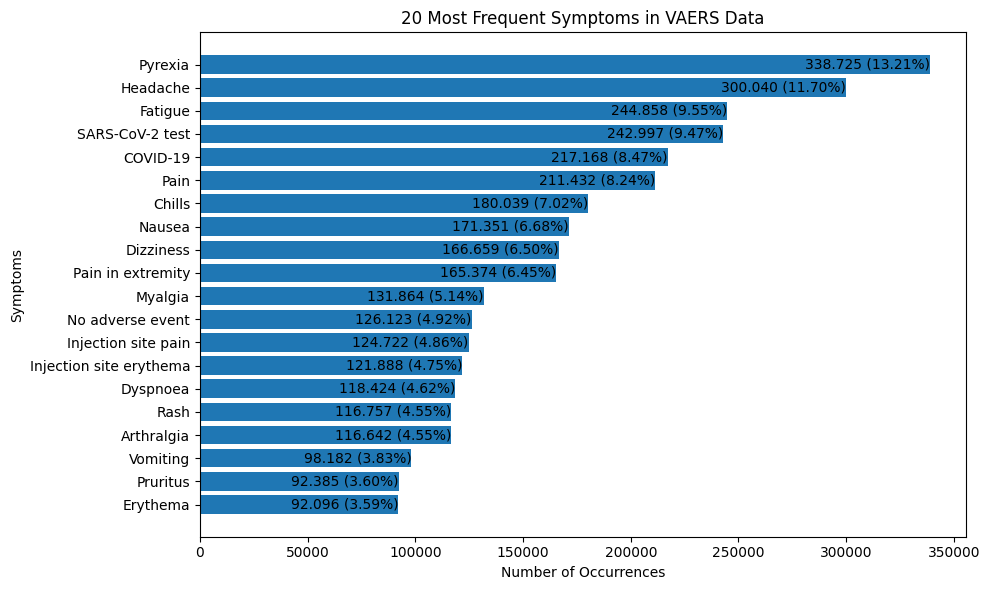

In [26]:
pipeline = [
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]
# Query the database for all documents
total_reports = collection.count_documents({})

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms in VAERS Data')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_alltime.png')

    plt.show()
else:
    print("No data found.")

# Most common symptoms from 1990 to 2023

# Now for people that got vaccinated with the COVID-19 vaccine

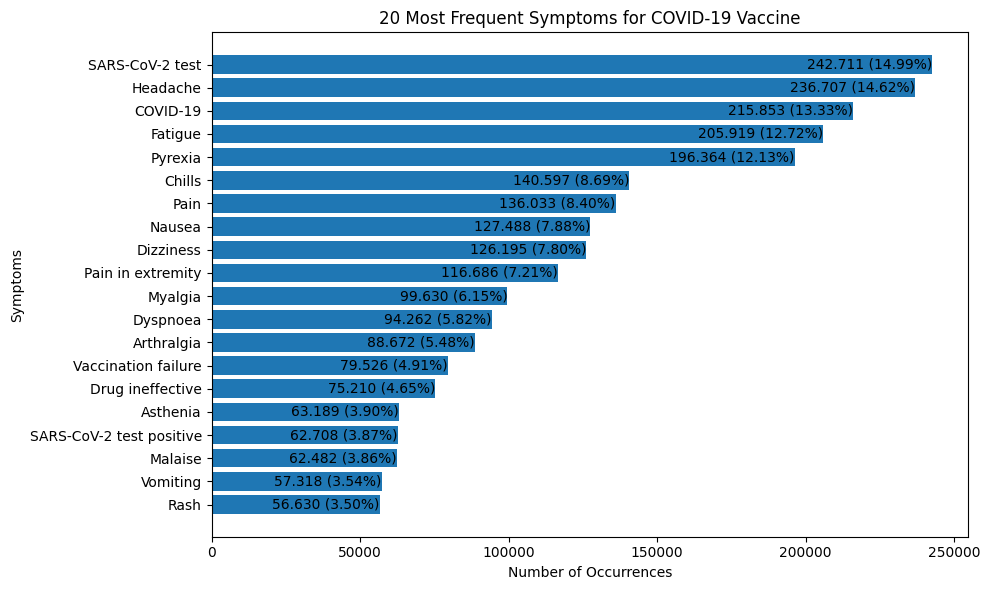

In [28]:
import re

# Count total reports containing COVID in vax_data.VAX_TYPE
total_reports = collection.count_documents({"vax_data.VAX_TYPE": {"$regex": "COVID"}})

pipeline = [
    # Match documents where vax_data.VAX_TYPE contains "COVID"
    {"$match": {"vax_data.VAX_TYPE": {"$regex": "COVID"}}},  
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms for COVID-19 Vaccine')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID.png')

    plt.show()
else:
    print("No data found.")

# Now for every other vaccine besides COVID-19

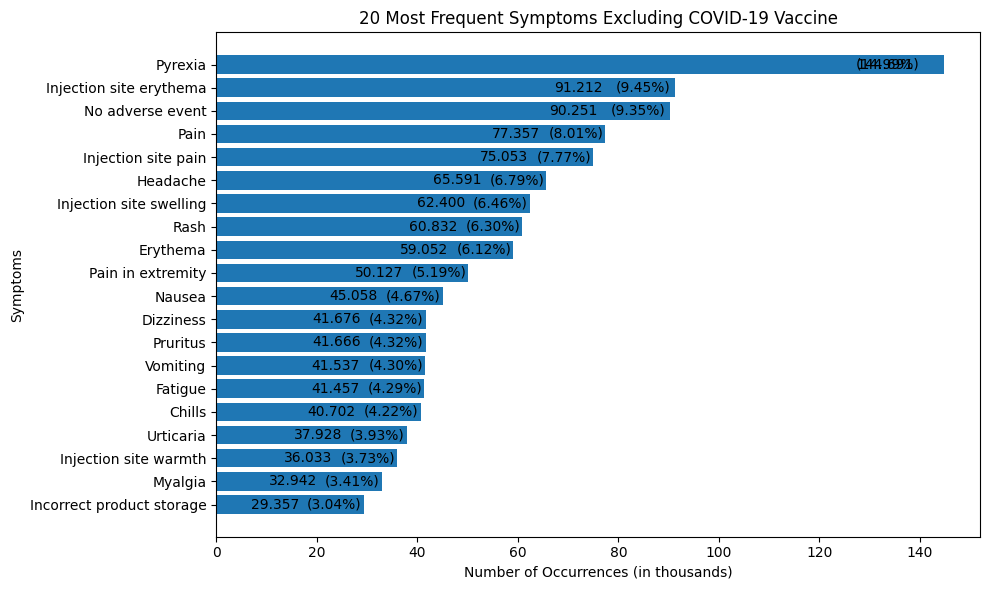

In [31]:
# Regex pattern to match any characters except "COVID" in vax_type
non_covid_pattern = re.compile(r'^(?!.*COVID).*$', re.IGNORECASE)

# Query the database for documents with "COVID" in the vax_type field within the vax_data array
query = {'vax_data.VAX_TYPE': non_covid_pattern}
non_covid_documents_cursor = collection.find(query)

# Initialize a Counter object to count symptoms
symptom_counter = Counter()

# Get the total number of documents that match the query
non_covid_document_count = collection.count_documents(query)

# Check if there are any documents that match the COVID query
if non_covid_document_count == 0:
    raise ValueError("No documents found with COVID vaccine in the data.")

# Process documents to count symptoms
for document in non_covid_documents_cursor:
    # Check if 'symptoms' exists and is a list (iterable)
    if 'symptoms' in document and isinstance(document['symptoms'], list):
        symptom_counter.update(document['symptoms'])

# Check if there are any symptoms to process
if not symptom_counter:
    raise ValueError("No symptoms found for COVID vaccines in the data.")



# Get the 20 most common symptoms
most_common_symptoms = symptom_counter.most_common(20)

# Extract symptoms and counts for plotting
symptoms, counts = zip(*most_common_symptoms)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(symptoms, counts)

# Set titles and labels
plt.title('20 Most Frequent Symptoms Excluding COVID-19 Vaccine')
plt.xlabel('Number of Occurrences (in thousands)')
plt.ylabel('Symptoms')

# Define a custom formatter function to display x-axis labels in thousands
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}'

# Set the custom formatter for the x-axis
plt.gca().xaxis.set_major_formatter(thousands_formatter)

# Add data labels and percentages to the bars
for bar in bars:
    label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
    percentage = (bar.get_width() / non_covid_document_count) * 100
    if bar.get_width() > 100000:
        total_offset = -17250
        percent_offset = -17500
    elif bar.get_width() > 80000:
        total_offset = -24000
        percent_offset = -11750
    else:
        total_offset = -22500
        percent_offset = -11250
    
    x_position = bar.get_width()
    plt.text(x_position + total_offset, bar.get_y() + bar.get_height() / 2,
             label,
             va='center', ha='left', color='black')
    
    # Add percentage next to the total number
    plt.text(x_position + percent_offset, bar.get_y() + bar.get_height() / 2,
             f'({percentage:.2f}%)',
             va='center', ha='left', color='black')
    

# Invert y-axis to have the most common symptom at the top
plt.gca().invert_yaxis()

plt.tight_layout()

# Save the plot
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_ExcludingCOVID.png')
plt.show()

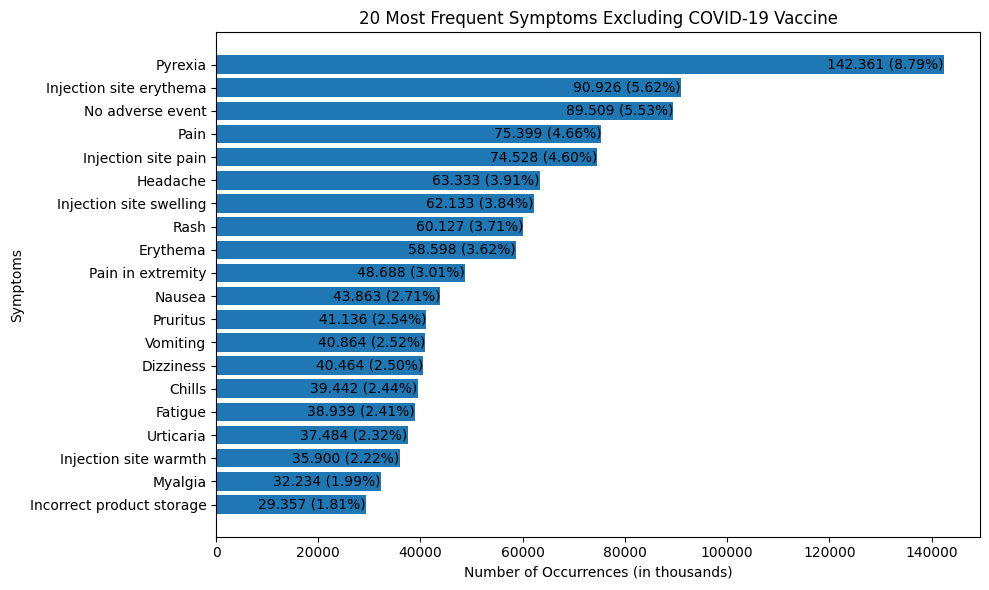

In [30]:
# Count total reports not containing COVID in vax_data.VAX_TYPE
total_reports = collection.count_documents({"vax_data.VAX_TYPE": {"$not": re.compile("COVID")}})

pipeline = [
    # Match documents where at least one vaccine in vax_data.VAX_TYPE is non-COVID
    {"$match": {"vax_data.VAX_TYPE": {"$not": re.compile("COVID")}}},  
    # Unwind the 'symptoms' array field
    {"$unwind": "$symptoms"},
    # Group by symptom and count occurrences
    {"$group": {"_id": "$symptoms", "count": {"$sum": 1}}},
    # Sort by count in descending order
    {"$sort": {"count": -1}},
    # Limit to the top 20 most common symptoms
    {"$limit": 20}
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

if result:
    # Extract symptoms and counts for plotting
    symptoms = [doc['_id'] for doc in result]
    counts = [doc['count'] for doc in result]

    # Calculate percentages
    percentages = [(count / total_reports) * 100 for count in counts]

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(symptoms, counts)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
        percentage = percentages[i]
        x_position = bar.get_width()
        plt.text(x_position, bar.get_y() + bar.get_height() / 2,
                 f'{label} ({percentage:.2f}%)',
                 va='center', ha='right', color='black')  # Align the text to end at the end of the bar

    # Set titles and labels
    plt.title('20 Most Frequent Symptoms Excluding COVID-19 Vaccine')
    plt.xlabel('Number of Occurrences (in thousands)')
    plt.ylabel('Symptoms')

    # Invert y-axis to have the most common symptom at the top
    plt.gca().invert_yaxis()

    plt.tight_layout()

    # Save the plot
    plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_ExcludingCOVID.png')

    plt.show()
else:
    print("No data found.")

# Symptoms per manufacturer

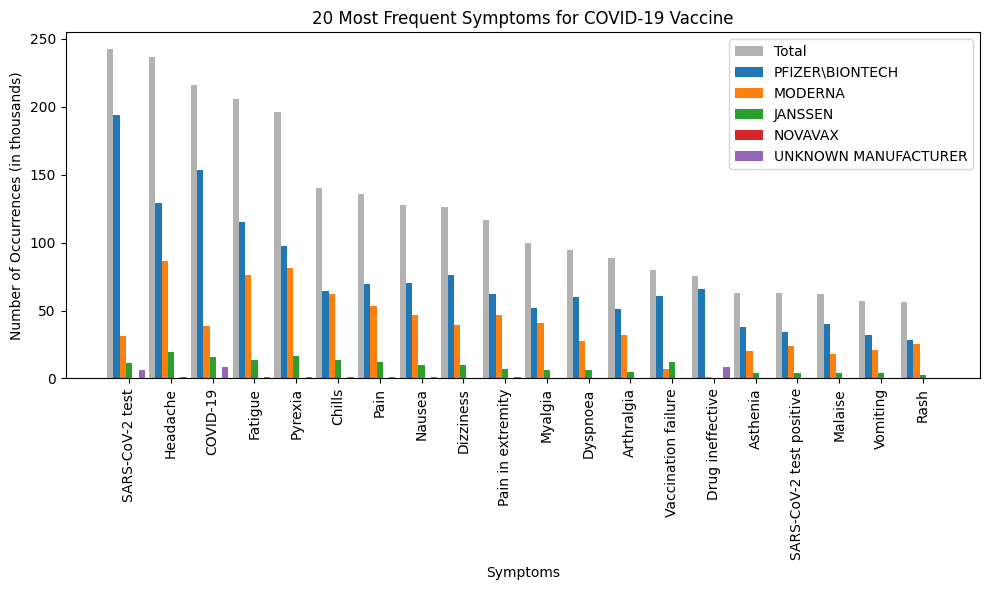

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

# Specify the manufacturers to include
target_manufacturers = ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'NOVAVAX', 'UNKNOWN MANUFACTURER']

# Initialize a dictionary to store symptoms per manufacturer
symptoms_per_manufacturer = {manu: {} for manu in target_manufacturers}

# Query the database for documents with specified manufacturers and VAX_TYPE including 'COVID'
query = {
    'vax_data.VAX_MANU': {'$in': target_manufacturers},
    'vax_data.VAX_TYPE': {'$regex': 'COVID', '$options': 'i'}
}
projection = {'VAERS_ID': True, 'vax_data.VAX_MANU': True, 'symptoms': True}
documents_cursor = collection.find(query, projection)

# Process documents to count symptoms
for document in documents_cursor:
    # Extract all VAX_MANU entries for the document
    manufacturers = [entry['VAX_MANU'] for entry in document.get('vax_data', []) if 'VAX_MANU' in entry]

    # Intersect the manufacturers list with the target manufacturers
    intersected_manufacturers = set(manufacturers).intersection(set(target_manufacturers))

    # If there's no intersection, skip this document
    if not intersected_manufacturers:
        continue
    
    # Assume that a document cannot have more than one vaccine manufacturer from the target list
    manufacturer = intersected_manufacturers.pop()
    
    # Ensure symptoms_list is always a list
    symptoms_list = document.get('symptoms', [])
    if not isinstance(symptoms_list, list):
        symptoms_list = [symptoms_list]  # Convert to list if not already
    
    for symptom in symptoms_list:
        if symptom:  # Check if symptom is not empty
            symptoms_per_manufacturer[manufacturer].setdefault(symptom, 0)
            symptoms_per_manufacturer[manufacturer][symptom] += 1

# Convert the dictionary to DataFrame
df = pd.DataFrame(symptoms_per_manufacturer).fillna(0)

# Sum the counts of each symptom across all manufacturers
df['Total'] = df.sum(axis=1)

# Select the top 20 most frequent symptoms
top_20_symptoms = df['Total'].sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.15
index = range(len(top_20_symptoms))

# Calculate total counts for top 20 symptoms
total_counts = df['Total'][top_20_symptoms.index]

# Plot total bar first
plt.bar(index, total_counts, width=bar_width, label='Total', color='k', alpha=0.3)

# Plot bars for individual manufacturers
for i, manufacturer in enumerate(target_manufacturers):
    if manufacturer in df.columns:
        symptom_counts = [df.at[symptom, manufacturer] for symptom in top_20_symptoms.index]
        plt.bar([x + bar_width * (i + 1) for x in index], symptom_counts, width=bar_width, label=manufacturer)

# Adding labels and title
plt.xlabel('Symptoms')
plt.ylabel('Number of Occurrences (in thousands)')
plt.title('20 Most Frequent Symptoms for COVID-19 Vaccine')
plt.xticks([x + bar_width * (len(target_manufacturers) + 1) / 2 for x in index], top_20_symptoms.index, rotation=90)  # Rotate x-axis labels for better visibility
plt.legend()  # Show legend

# Define custom formatter function for y-axis
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}'

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(thousands_formatter)

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID_byManufacturer_total.png')
plt.show()

In [140]:
df

,PFIZER\BIONTECH,MODERNA,JANSSEN,NOVAVAX,UNKNOWN MANUFACTURER,Total
Extra dose administered,4690.0,4446.0,462.0,10.0,51.0,9659.0
Interchange of vaccine products,26759.0,5001.0,738.0,16.0,594.0,33108.0
Incorrect route of product administration,2201.0,793.0,52.0,0.0,25.0,3071.0
No adverse event,15291.0,20111.0,1157.0,18.0,37.0,36614.0
Inappropriate schedule of product administration,21954.0,8266.0,315.0,7.0,179.0,30721.0
...,...,...,...,...,...,...
Pericardial cyst resection,0.0,0.0,0.0,0.0,1.0,1.0
Enterostomy,0.0,0.0,0.0,0.0,1.0,1.0
Bone giant cell tumour,0.0,0.0,0.0,0.0,1.0,1.0
Rheumatoid lung,0.0,0.0,0.0,0.0,1.0,1.0


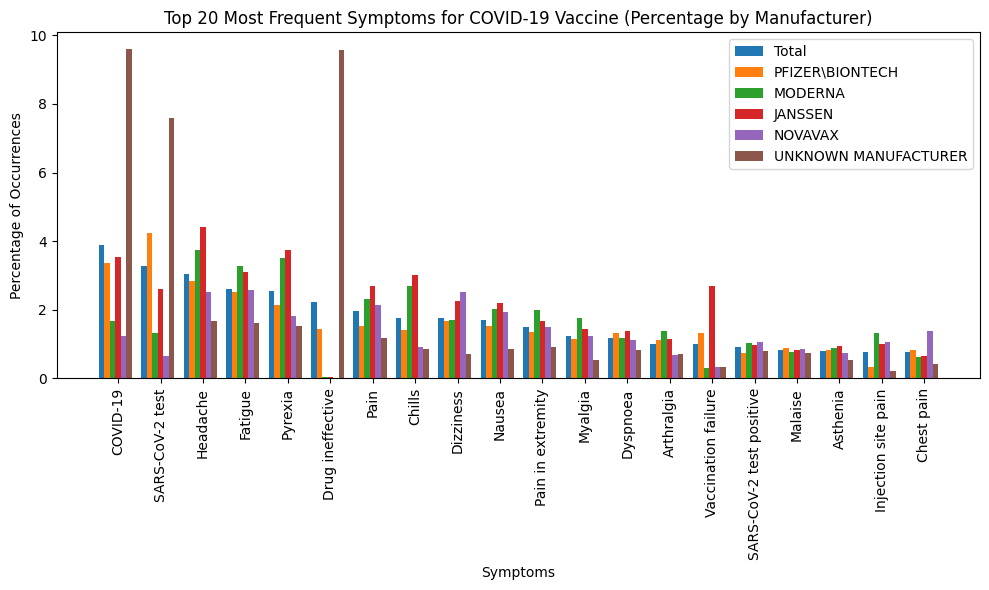

In [137]:
# Specify the manufacturers to include
target_manufacturers = ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'NOVAVAX', 'UNKNOWN MANUFACTURER']

# Initialize a dictionary to store symptoms per manufacturer
symptoms_per_manufacturer = {manu: {} for manu in target_manufacturers}

# Query the database for documents with specified manufacturers and VAX_TYPE including 'COVID'
query = {
    'vax_data.VAX_MANU': {'$in': target_manufacturers},
    'vax_data.VAX_TYPE': {'$regex': 'COVID', '$options': 'i'}
}
projection = {'VAERS_ID': True, 'vax_data.VAX_MANU': True, 'vax_data.VAX_TYPE': True ,'symptoms': True}
documents_cursor = collection.find(query, projection)

# Process documents to count symptoms
for document in documents_cursor:
    covid_vaccine_present = any(entry.get('VAX_TYPE', '').startswith('COVID') for entry in document.get('vax_data', []))

    if not covid_vaccine_present:
        continue  # Skip processing this document if no COVID vaccine is found

    # Extract all VAX_MANU entries for the document
    manufacturers = [entry['VAX_MANU'] for entry in document.get('vax_data', []) if 'VAX_MANU' in entry]

    # Intersect the manufacturers list with the target manufacturers
    intersected_manufacturers = set(manufacturers).intersection(set(target_manufacturers))

    # If there's no intersection, skip this document
    if not intersected_manufacturers:
        continue
    
    # Assume that a document cannot have more than one vaccine manufacturer from the target list
    manufacturer = intersected_manufacturers.pop()
    
    # Ensure symptoms_list is always a list
    symptoms_list = document.get('symptoms', [])
    if not isinstance(symptoms_list, list):
        symptoms_list = [symptoms_list]  # Convert to list if not already
    
    for symptom in symptoms_list:
        if symptom:  # Check if symptom is not empty
            symptoms_per_manufacturer[manufacturer].setdefault(symptom, 0)
            symptoms_per_manufacturer[manufacturer][symptom] += 1

# Convert the dictionary to DataFrame
df = pd.DataFrame(symptoms_per_manufacturer).fillna(0)

# Calculate the total number of symptoms per manufacturer
total_symptoms_per_manufacturer = df.sum(axis=0)

# Calculate the percentage of each symptom for each manufacturer
for manufacturer in target_manufacturers:
    if manufacturer in df.columns:
        df[manufacturer] = df[manufacturer] / total_symptoms_per_manufacturer[manufacturer] * 100

# Select the top 20 most frequent symptoms
top_20_symptoms = df.sum(axis=1).nlargest(20)

# Define the order of manufacturers for plotting
plot_order = ['Total'] + target_manufacturers

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.13
index = range(len(top_20_symptoms))

# Calculate and plot the total bar first
total_percentages = df.sum(axis=1) / len(target_manufacturers)
plt.bar(index, total_percentages.loc[top_20_symptoms.index], width=bar_width, label='Total')

# Plot bars for individual manufacturers
for i, manufacturer in enumerate(target_manufacturers):
    if manufacturer in df.columns:
        symptom_percentages = [df.at[symptom, manufacturer] for symptom in top_20_symptoms.index]
        plt.bar([x + bar_width * (i + 1) for x in index], symptom_percentages, width=bar_width, label=manufacturer)

# Adding labels and title
plt.xlabel('Symptoms')
plt.ylabel('Percentage of Occurrences')
plt.title('Top 20 Most Frequent Symptoms for COVID-19 Vaccine (Percentage by Manufacturer)')
plt.xticks([x + bar_width * len(plot_order) / 2 for x in index], top_20_symptoms.index, rotation=90)  # Rotate x-axis labels for better visibility
plt.legend()  # Show legend

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID_byManufacturer.png')
plt.show()

In [138]:
total_symptoms_per_manufacturer

PFIZER\BIONTECH         4559034.0
MODERNA                 2315504.0
JANSSEN                  438467.0
NOVAVAX                    1871.0
UNKNOWN MANUFACTURER      85217.0
dtype: float64

In [111]:
df

,PFIZER\BIONTECH,MODERNA,JANSSEN,NOVAVAX,UNKNOWN MANUFACTURER
Extra dose administered,0.102873,0.192010,0.105367,0.534474,0.059847
Interchange of vaccine products,0.586945,0.215979,0.168314,0.855158,0.697044
Incorrect route of product administration,0.048278,0.034247,0.011860,0.000000,0.029337
No adverse event,0.335400,0.868537,0.263874,0.962052,0.043419
Inappropriate schedule of product administration,0.481549,0.356985,0.071841,0.374131,0.210052
...,...,...,...,...,...
Pericardial cyst resection,0.000000,0.000000,0.000000,0.000000,0.001173
Enterostomy,0.000000,0.000000,0.000000,0.000000,0.001173
Bone giant cell tumour,0.000000,0.000000,0.000000,0.000000,0.001173
Rheumatoid lung,0.000000,0.000000,0.000000,0.000000,0.001173


In [46]:
target_manufacturers

['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'NOVAVAX', 'UNKNOWN MANUFACTURER']

In [47]:
total_percentages

Extra dose administered                             0.198914
Interchange of vaccine products                     0.504688
Incorrect route of product administration           0.024744
No adverse event                                    0.494656
Inappropriate schedule of product administration    0.298912
                                                      ...   
Pericardial cyst resection                          0.000235
Enterostomy                                         0.000235
Bone giant cell tumour                              0.000235
Rheumatoid lung                                     0.000235
Vaccine interaction                                 0.000235
Length: 15541, dtype: float64

In [120]:
pipeline = [
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"},
            "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER",
            "symptoms": {"$exists": True}  # Ensure the document has a "symptoms" field
        }
    },
    {
        "$unwind": "$symptoms"  # Deconstruct the 'symptoms' array field
    },
    {
        "$group": {
            "_id": None,  # Group all documents together
            "total_symptoms_count": {"$sum": 1}  # Count the total number of symptoms
        }
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

# Extract the total number of symptoms
if result:
    total_symptoms_count = result[0]["total_symptoms_count"]
    print("Total number of symptoms for UNKNOWN MANUFACTURER for VAX_TYPE COVID:", total_symptoms_count)
else:
    print("No symptoms found for UNKNOWN MANUFACTURER for VAX_TYPE COVID.")


Total number of symptoms for UNKNOWN MANUFACTURER for VAX_TYPE COVID: 108683


In [129]:
pipeline = [
    {
        "$match": {
            "vax_data": {
                "$elemMatch": {
                    "VAX_TYPE": {"$regex": "COVID"},
                    "VAX_MANU": "UNKNOWN MANUFACTURER"
                }
            },
            "symptoms": {"$exists": True}  # Ensure the document has a "symptoms" field
        }
    },
    {
        "$unwind": "$vax_data"  # Deconstruct the 'vax_data' array field
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"}  # Remove non-COVID vaccines
        }
    },
    {
        "$group": {
            "_id": None,  # Group all documents together
            "total_symptoms_count": {"$sum": {"$size": "$symptoms"}}  # Count the total number of symptoms
        }
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

# Extract the total number of symptoms
if result:
    total_symptoms_count = result[0]["total_symptoms_count"]
    print("Total number of symptoms for UNKNOWN MANUFACTURER for VAX_TYPE COVID:", total_symptoms_count)
else:
    print("No symptoms found for UNKNOWN MANUFACTURER for VAX_TYPE COVID.")


Total number of symptoms for UNKNOWN MANUFACTURER for VAX_TYPE COVID: 93677


In [112]:
pipeline = [
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"},
            "vax_data.VAX_MANU": "UNKNOWN MANUFACTURER",
            "symptoms": {"$exists": True}  # Ensure the document has a "symptoms" field
        }
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

unique_vax_types = set()

# Iterate through each document in the result
for document in result:
    # Check if 'vax_data' exists in the document
    if 'vax_data' in document:
        # Iterate through each entry in 'vax_data'
        for entry in document['vax_data']:
            # Extract the 'VAX_TYPE' value and add it to the set
            if 'VAX_TYPE' in entry:
                unique_vax_types.add(entry['VAX_TYPE'])

# Print the unique VAX_TYPE values
print("Unique VAX_TYPE values:")
for vax_type in unique_vax_types:
    print(vax_type)

Unique VAX_TYPE values:
VARCEL
RVX
COVID19
MENHIB
RAB
FLUR4
HPV9
MNQ
IPV
MENB
VARZOS
HPVX
MEN
TTOX
TYP
YF
FLUX
DTP
HEP
HIBV
BCG
DTOX
COVID19-2
HEPA
TD
HEPAB
SMALL
MEA
DTPPVHBHPB
CEE
FLU3
FLUA4
DTAPIPVHIB
DTAPIPV
MMR
FLUC3
DTAP
MMRV
PPV
UNK
RSV
JEVX
FLUA3
PNC20
FLUC4
HPV2
ADEN_4_7
FLUN3
FLUX(H1N1)
DTPIPV
SMALLMNK
PNC15
FLU4
PNC
DTIPV
TDAP
HPV4
PNC13
MU
TBE
RV1
DT
DTAPHEPBIP
CHOL


In [128]:
pipeline = [
    {
        "$match": {
            "vax_data": {
                "$elemMatch": {
                    "VAX_TYPE": {"$regex": "COVID"},
                    "VAX_MANU": "UNKNOWN MANUFACTURER"
                }
            },
            "symptoms": {"$exists": True}  # Ensure the document has a "symptoms" field
        }
    },
    {
        "$unwind": "$vax_data"  # Deconstruct the 'vax_data' array field
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

# Print the vax_data entry after unwinding
for entry in result:
    print("vax_data entry after unwinding:")
    print(entry)
    break


vax_data entry after unwinding:
{'_id': ObjectId('65d3a39b6b9531e46fbc4645'), 'VAERS_ID': 1438945, 'RECVDATE': datetime.datetime(2021, 6, 30, 0, 0), 'TODAYS_DATE': datetime.datetime(2021, 6, 30, 0, 0), 'STATE': 'MO', 'AGE': 69.0, 'SEX': 'F', 'SERIOUS': 'Y', 'DIED': nan, 'DATEDIED': nan, 'L_THREAT': nan, 'ER_VISIT': nan, 'HOSPITAL': nan, 'HOSPDAYS': nan, 'X_STAY': nan, 'DISABLE': 'Y', 'RECOVD': 'N', 'VAX_DATE': datetime.datetime(2021, 2, 19, 0, 0), 'ONSET_DATE': datetime.datetime(2021, 3, 22, 0, 0), 'NUMDAYS': 31.0, 'OTHER_MEDS': ['LEVOXYL 88 MCG', 'SIMVASTATIN 20 MG', 'CALCIUM +D X 2', 'BIOTIN X 2'], 'CUR_ILL': ['NONE'], 'HISTORY': ["HASHIMOTO'S", 'HIGH LDL', 'FOOD INDUCED HYPOGLYCEMIA'], 'PRIOR_VAX': nan, 'BIRTH_DEFECT': nan, 'OFC_VISIT': 'Y', 'ER_ED_VISIT': nan, 'ALLERGIES': 'CODEINE', 'vax_data': {'VAX_TYPE': 'COVID19', 'VAX_MANU': 'UNKNOWN MANUFACTURER', 'VAX_LOT': '043L20A', 'VAX_DOSE_SERIES': '1', 'VAX_NAME': 'COVID19 (COVID19 (UNKNOWN))'}, 'symptoms': ['ACTH stimulation test', '